# SED-ML script (python examples)
https://docs.google.com/document/d/1HzX0GcwoG_dcA_Zwuud0r7ICyH9WfSuJX_4lXxdJImc/edit#

In [21]:
import roadrunner
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def outputVariables(model, selections=None, complete=False):
    """ Select output variables for simulation."""
    if complete:
        species_ids = model.model.getBoundarySpeciesIds() + model.model.getFloatingSpeciesIds()
        selections = ["time"] + species_ids + [f'[{sid}]' for sid in species_ids] \
            + model.model.getReactionIds() + model.model.getCompartmentIds() + model.model.getParameterIds()
    
    model.timeCourseSelections = selections
    model.steadyStateSelections = selections

    
def model(path):
    return roadrunner.RoadRunner(path)

def uniform(model, start, end, steps=1, stochastic=False):
    if stochastic:
        model.setIntegrator('gillespie')
        s = model.simulate(start, end)
    else:
        s = model.simulate(start, end, steps)
    return pd.DataFrame(s, columns=s.colnames)


def onestep(model, end, stochastic=False):
    if stochastic:
        rr.setIntegrator('gillespie')
        s = model.simulate(0, end)
    else:
        s = model.simulate(0, end, steps=1)
    df = pd.DataFrame(s, columns=s.colnames)
    return df.tail(1)


class dotdict(dict):
    """dot.notation access to dictionary attributes.
    Special dicts needed.
    """
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

## Comparisons
```
  model1 = model("BIOMD0000000021.xml")
  model2 = model1
  model2.V_mT = 0.28
  model2.V_dT = 4.8
  task1 = model1.uniform(0, 380, 1000)
  task2 = model2.uniform(0, 380, 1000)
  p1 = plot(task1.time, [task1.Mt, task2.Mt])
  p2 = plot(task1.Cn, task1.Mt)
  p2.addPlot(task2.Cn, task2.Mt)

  p1.show()
  p2.show()
```

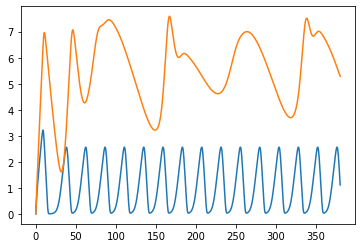

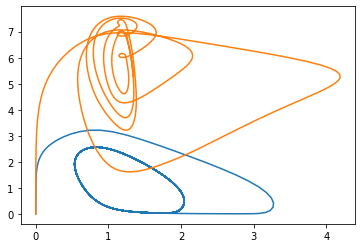

In [9]:
model1 = model("BIOMD0000000021.xml")
# FIXME: necessary to define what is collected!
# any defaults here? (time and species amounts/concentrations? for SBML)
outputVariables(model1, complete=True)

# FIXME: copy of roadrunner objects not possible 
# (see reported issue https://github.com/sys-bio/roadrunner/issues/469)
# We have to reload here
# model2 = model1
model2 = model("BIOMD0000000021.xml")
outputVariables(model2, complete=True)
model2.V_mT = 0.28
model2.V_dT = 4.8


# unclear what 1000 is (steps or points, being explicit here)
task1 = uniform(model1, start=0, end=380, steps=1000)
task2 = uniform(model2, start=0, end=380, steps=1000)

# FIXME: how to access amounts and concentrations?
fig, p1 = plt.subplots()
# p1 is an axes! stacking the vectors to plot at the same time
p1.plot(task1.time, np.stack([task1['[Mt]'], task2['[Mt]']], axis=1))

fig, p2 = plt.subplots()
p2.plot(task1['[Cn]'], task1['[Mt]'])
p2.plot(task2['[Cn]'], task2['[Mt]'])
plt.show()

## Perturbations
```
  model1 = model("oscli.xml")
  task1 = {"time" : range(0, 10.1, 0.1), "S1" : [], "S2", [], "J0_v0", []}
  for x in task1.time:
    if(x>=4 and x < 6):
        model1.J0_v0 = 0.1
    else:
        model1.J0_v0 = 8
    model1.onestep(0.1)
    for element in ['S1', 'S2', 'J0_v0']:
        task1[element].append(model1[element])
  plot(task1.time, [task1.S1, task1.S2, task1.J0_v0])
```

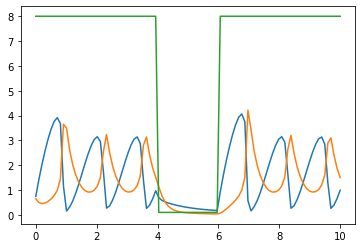

In [10]:
model1 = model("oscli.xml")
outputVariables(model1, ["time", "S1", "S2", "J0_v0"])

# FIXME: basic vectors ! linspace, logspace, zeros_like, ones_like
time = np.linspace(start=0, stop=10, num=100)
task1 = dotdict({
    "time" : time,
    "S1" : np.zeros_like(time), 
    "S2" : np.zeros_like(time), 
    "J0_v0": np.zeros_like(time)
})
# enumerate is very powerful! access to indices
for k, x in enumerate(task1["time"]):
    if (x >= 4 and x < 6):
        model1.J0_v0 = 0.1
    else:
        model1.J0_v0 = 8
    # FIXME: the results have to be returned (are not in the model)
    s = onestep(model1, 0.1)
    # FIXME: unclear amount/concentration
    for element in ['S1', 'S2', 'J0_v0']:
        # doing via index not via append
        task1[element][k] = s[element]

plt.plot(task1.time, np.stack([task1.S1, task1.S2, task1.J0_v0], axis=1))
plt.show()

## Repeated stochastic simulation
```
  model1 = model("borisejb.xml")
  model1.outputVariables(["MAPK", "MAPK_P", "MAPK_PP", "MKK_P", "MKKK", "MKKK_P"])
  p1 = plot()
  for x in range(10):
    mod = model1
    onesim = mod.uniform(0, 4000, stochastic=True, seed = 1003*(x+1))
    p1.addPlot(onesim, x="time")
  p1.show()
```

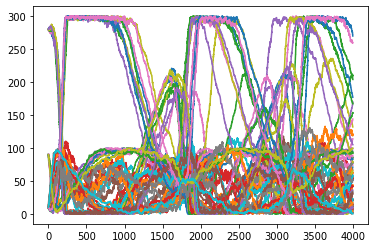

In [11]:
model1 = model("borisejb.xml")
# FIXME: time belongs in the outputVariables
# FIXME: use vector
variableIds = ["MAPK", "MAPK_P", "MAPK_PP", "MKK_P", "MKKK", "MKKK_P"]
outputVariables(model1, ["time"] + variableIds)

fig, p1 = plt.subplots()
for x in range(10):
    # FIXME: we need either a reset here, or a real model copy
    mod = model1
    mod.resetAll()
    
    # FIXME: seed can be set anywhere in simulation script!
    np.random.seed(1003*(x+1))
    onesim = uniform(mod, 0, 4000, stochastic=True)
    p1.plot(onesim.time, onesim[variableIds])

## 1D time course parameter scan
```
  model1 = model("oscli.xml")
  p1 = plot()
  for j0 in [8, 4, 0.4]:
    mod = model1
    mod.J0_v0 = j0
    onesim = mod.uniform(0, 20, 0.01)
    p1.addPot(onesim, x="time")
  p1.show()

```

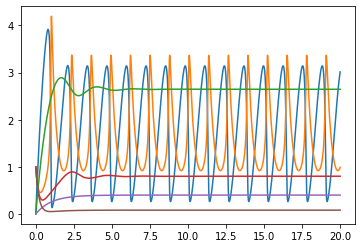

In [12]:
model1 = model("oscli.xml")
# FIXME: output variables must be set (what are defaults otherwise?)
speciesIds = ["S1", "S2"]
outputVariables(model1, ["time"] + speciesIds)

fig, p1 = plt.subplots()
for j0 in [8, 4, 0.4]:
    # FIXME copy or reference needed
    mod = model1
    mod.resetAll()
    
    mod.J0_v0 = j0
    onesim = uniform(mod, 0, 20, steps=2000)
    p1.plot(onesim.time, onesim[speciesIds])


## 2D steady state parameter scan
```
  model_3 = model("borisejb.xml")
  results = dictionary()
  key_species = ["J4_KK5", "MKK", "MKK_P"] 
  for element in key_species:
    results[element] = []
  for kk5 in range(1, 40.4, 0.4):
    for kk2 in [1, 5, 10, 50, 60, 70, 80, 90, 100]:
        mod = model_3
        mod.J4_KK5 = kk5
        mod.J1_KK2 = kk2
        mod.steadystate()
        results.merge(mod)
  plot(results, x="J4_KK5")
```

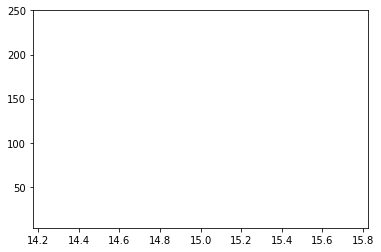

{'J4_KK5': [15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0], '[MKK]': [238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 238.9137255206713, 

In [28]:
# this is not working

def steadystate(model):
    """Calculate steady state for model."""
    model.conservedMoietyAnalysis = True
    solver = model.getSteadyStateSolver()
    
    # solver.setSetting("maximum_iterations", 500)
    
    d = dict()
    try:
        model.steadyState()
        
        s = model.getSteadyStateValues()
        for k, key in enumerate(model.steadyStateSelections):
            d[key] = s[k]
    
    except RuntimeError:
        for key in model.steadyStateSelections:
             d[key] = np.nan
    return d


model3 = model("borisejb.xml")
# FIXME: set variables
keys = ["J4_KK5", "[MKK]", "[MKK_P]"]
outputVariables(model3, ["J4_KK5", "[MKK]", "[MKK_P]"])

results = dotdict()
for element in keys:
    results[element] = []

# FIXME: is the range correct?
# for kk5 in range(1, 40.4, 0.4):
for kk5 in np.linspace(start=1, stop=40, num=10):
    for kk2 in [1, 5, 10, 50, 60, 70, 80, 90, 100]:
        # FIXME model copy
        mod = model3
        mod.resetAll()
        mod.J4_KK5 = kk5
        mod.J1_KK2 = kk2
        
        s = steadystate(mod)
        # FIXME: this merge will not work
        # results.merge(mod)
        for key in keys:
            # FIXME: steady state returns only concentrations, probably selections not correct
            # model state not updated
            results[key].append(mod[key])

# convert to DataFrame for plotting
plt.plot(results["J4_KK5"], pd.DataFrame(results))
plt.show()

# FIXME: many steady states are not feasible
print(results)